# warning!!!!!!!!!!!!!!
- 본 노트북의 코드는 현재 업데이트된 streamlit 코드와 호환되지 않는 부분이 많으므로 혹시 해당 노트북에서 코드를 발췌하여 사용하지 않도록 주의해주세요!!!!!

In [ ]:
from moviepy import VideoFileClip

VideoFileClip('hong.gif').write_videofile('hong_test.mp4')

# video generation test

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt


# Initializing mediapipe pose class.
mp_pose = mp.solutions.pose
# Setting up the Pose model for images.
pose_img = mp_pose.Pose(static_image_mode=True, min_detection_confidence=0.5, model_complexity=1)
# Setting up the Pose model for videos.
pose_video = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, 
                          min_tracking_confidence=0.5, model_complexity=1)

# Initializing mediapipe drawing class to draw landmarks on specified image.
mp_drawing = mp.solutions.drawing_utils


def estimPose_img(input_file, pose=pose_img, landmarks_c=(234,63,247), connection_c=(117,249,77), 
                   thickness=20, circle_r=10, display=True):
    
    # Read the input image
    if isinstance(input_file, str) :
        input_img = cv2.imread(input_file)
    else :
        input_img = input_file
    
    # Create a copy of the input image
    output_img = input_img.copy()
    
    # Perform the Pose Detection.
    results = pose.process(output_img) # 이거 이렇게 하면 트래킹은 안되자나..
    # Retrieve the height and width of the input image.
    height, width, _ = input_img.shape
    
    # Initialize a list to store the detected landmarks.
    landmarks = []
    
    # Check if any landmarks are detected.
    if results.pose_landmarks:
        skeleton = np.zeros_like(input_img)
        mp_drawing.draw_landmarks(skeleton, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                  mp_drawing.DrawingSpec(landmarks_c, thickness, circle_r),
                                  mp_drawing.DrawingSpec(connection_c, thickness, circle_r))
    
        # Draw Pose landmarks on the output image.
        mp_drawing.draw_landmarks(output_img, results.pose_landmarks, mp_pose.POSE_CONNECTIONS, 
                                  mp_drawing.DrawingSpec(landmarks_c, thickness, circle_r),
                                  mp_drawing.DrawingSpec(connection_c, thickness, circle_r))
        
        # Iterate over the detected landmarks.
        for landmark in results.pose_world_landmarks.landmark:
            landmarks.append((landmark.x, landmark.y,
                                  landmark.z, landmark.visibility))
            
    # print(results.pose_landmarks)
    # Check if we want to display.
    if display:
        # Display the original input image and the resulting image.
        plt.figure(figsize=[15,15])
        plt.subplot(121);plt.imshow(input_img[:,:,::-1]);plt.title("Original image");plt.axis('off')
        plt.subplot(122);plt.imshow(output_img[:,:,::-1]);plt.title("Output image");plt.axis('off')
        
        # Plot the Pose landmarks in 3D.
        mp_drawing.plot_landmarks(results.pose_world_landmarks, mp_pose.POSE_CONNECTIONS)
        return output_img, skeleton, landmarks
        
    # Just get output_img and landmarks
    else:
        # Return the output image and the found landmarks.
        return output_img, skeleton, landmarks

def estimPose_video(input_file, pose_video=pose_video, landmarks_c=(234,63,247), connection_c=(117,249,77), 
                 thickness=1, circle_r=1, nrows_frames=4, ncols_frames=3):
    
    # Initialize the VideoCapture object to read from a video stored in the disk.
    video = cv2.VideoCapture(input_file)
    
    total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(video.get(cv2.CAP_PROP_FPS))
    frames = []
    original_video_frames = []
    only_skeleton_frames = []
    
    all_landmarks = []
    for i in range(total_frames):
        # Read a frame.
        ok, frame = video.read()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        original_video_frames.append(frame.copy())
    
        # Check if frame is not read properly.
        if not ok:
            # Break the loop.
            break
        
        # Get the width and height of the frame
        frame_height, frame_width, _ =  frame.shape
        # Resize the frame while keeping the aspect ratio.
        frame = cv2.resize(frame, (int(frame_width * (640 / frame_height)), 640))
        frame, skeleton, landmarks = estimPose_img(frame, pose_video, landmarks_c, connection_c, thickness, 
                              circle_r, display=False)
        frames.append(frame)
        all_landmarks.append(landmarks)
        only_skeleton_frames.append(skeleton)
    return original_video_frames, only_skeleton_frames, frames, all_landmarks

In [ ]:
original_video_frames, only_skeleton_frames, frames, _ = estimPose_video("../hong.mp4", thickness=5)

In [ ]:
len(frames)

In [4]:
H, W, C = frames[0].shape
fps = 30
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (W, H))

for frame in frames:
    out.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()

In [ ]:
import imageio.v3 as iio

output_path = "test.mp4"
iio.imwrite(output_path, frames, fps=30)

# image similarity

In [ ]:
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import cv2

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

def get_detection(img_path):
    base_options = python.BaseOptions(model_asset_path='../pose_landmarker.task')
    options = vision.PoseLandmarkerOptions(
        base_options=base_options,
        output_segmentation_masks=True)
    detector = vision.PoseLandmarker.create_from_options(options)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
    detection_result = detector.detect(mp_image)
    annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)
    plt.imshow(annotated_image)
    plt.show()
    
    return detection_result.pose_landmarks, detection_result.segmentation_masks, annotated_image
r, s, a = get_detection('../images/target_img.jpg')

In [3]:
import numpy as np

def get_area(segmentation_masks, thr=0.5):
    return np.sqrt(np.sum(segmentation_masks.numpy_view() > thr))

def refine_landmarks(landmarks):
    lst = []
    for landmark in landmarks:
        lst.append([landmark.x, landmark.y, landmark.z, landmark.visibility])
    return np.array(lst)

In [ ]:
target_landmarks, target_masks, target_annotated_image = get_detection("../images/target_img.jpg")
target_landmarks_np = refine_landmarks(target_landmarks[0])
target_area = get_area(target_masks[0])

right_landmarks, right_masks, right_annotated_image = get_detection("../images/right_pose_img.jpg")
right_landmarks_np = refine_landmarks(right_landmarks[0])
right_area = get_area(right_masks[0])

wrong_landmarks, wrong_masks, wrong_annotated_image = get_detection("../images/wrong_pose_img.jpg")
wrong_landmarks_np = refine_landmarks(wrong_landmarks[0])
wrong_area = get_area(wrong_masks[0])

In [5]:
from keypoint_map import *
from scoring import normalize_landmarks

normalized_target_landmarks_np = normalize_landmarks(target_landmarks_np)
normalized_right_landmarks_np =  normalize_landmarks(right_landmarks_np)
normalized_wrong_landmarks_np =  normalize_landmarks(wrong_landmarks_np)

# normalized_target_landmarks_np = filter_important_features(normalize_landmarks(target_landmarks_np))
# normalized_right_landmarks_np = filter_important_features(normalize_landmarks(right_landmarks_np))
# normalized_wrong_landmarks_np = filter_important_features(normalize_landmarks(wrong_landmarks_np))

### GPT가 알려준 유클리드 거리 점수

In [ ]:
def calculate_similarity(landmarks1, landmarks2):
    if landmarks1 is None or landmarks2 is None:
        return 0  # 비교 불가 시 유사성 0으로 처리
    
    if landmarks1.shape != landmarks2.shape:
        raise ValueError("both landmarks must have same shape!!")
    
    if landmarks1.shape[-1] == 4:
        landmarks1 = landmarks1[..., :3]
        landmarks2 = landmarks2[..., :3]
    # 평준화된 유클리드 거리 계산
    distance = np.linalg.norm(landmarks1 - landmarks2, axis=1)
    similarity = 1 / (1 + np.mean(distance))  # 유사성을 0~1로 정규화
    return similarity

print("target and right pose L1 score : ", calculate_similarity(normalized_target_landmarks_np, normalized_right_landmarks_np))
print("target and wrong pose L1 score : ", calculate_similarity(normalized_target_landmarks_np, normalized_wrong_landmarks_np))

### cosine similarity

In [ ]:
def cos_sim(landmarks1, landmarks2):
    if landmarks1.shape != landmarks2.shape:
        raise ValueError("both landmarks must have same shape!!")
    
    if landmarks1.shape[-1] == 4:
        landmarks1 = landmarks1[..., :3]
        landmarks2 = landmarks2[..., :3]
    landmarks1 = landmarks1.flatten()
    landmarks2 = landmarks2.flatten()
    return (1+np.dot(landmarks1, landmarks2)/(np.linalg.norm(landmarks1)*np.linalg.norm(landmarks2))) / 2

print(f"target and right pose sim : {cos_sim(normalized_target_landmarks_np, normalized_right_landmarks_np)}")
print(f"target and wrong pose sim : {cos_sim(normalized_target_landmarks_np, normalized_wrong_landmarks_np)}")

In [ ]:
print(f"target and right pose sim : {cos_sim(target_landmarks_np, right_landmarks_np)}")
print(f"target and wrong pose sim : {cos_sim(target_landmarks_np, wrong_landmarks_np)}")

### L2 norm

In [ ]:
print("target and right pose L2 distance : ", np.linalg.norm((normalized_target_landmarks_np - normalized_right_landmarks_np)[..., :3].flatten()))
print("target and wrong pose L2 distance : ", np.linalg.norm((normalized_target_landmarks_np - normalized_wrong_landmarks_np)[..., :3].flatten()))

### L1 norm

In [ ]:
print("target and right pose L1 distance : ", np.linalg.norm((normalized_target_landmarks_np - normalized_right_landmarks_np)[..., :3].flatten(), ord=1))
print("target and wrong pose L1 distance : ", np.linalg.norm((normalized_target_landmarks_np - normalized_wrong_landmarks_np)[..., :3].flatten(), ord=1))

### weighted distance

In [ ]:
from keypoint_map import WEIGHTS, KEYPOINT_MAPPING
def weighted_distance(A, B, weights = WEIGHTS):
    d = 0.0
    
    for i in range(NUM_CLASSES):
        d += weights[KEYPOINT_MAPPING[i]] * np.linalg.norm(A[i] - B[i], ord=1)
    return d

print("target and right pose weighted L1 distance : ", weighted_distance(normalized_target_landmarks_np[..., :3], normalized_right_landmarks_np[..., :3]))
print("target and wrong pose weighted L1 distance : ", weighted_distance(normalized_target_landmarks_np[..., :3], normalized_wrong_landmarks_np[..., :3]))

# Video Similarity

In [29]:
import mediapipe as mp
import cv2

BaseOptions = mp.tasks.BaseOptions
PoseLandmarker = mp.tasks.vision.PoseLandmarker
PoseLandmarkerOptions = mp.tasks.vision.PoseLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose

options = PoseLandmarkerOptions(
    base_options=BaseOptions(model_asset_path='pose_landmarker.task'),
    running_mode=VisionRunningMode.VIDEO)

def get_video_detection(video_path, landmarks_c=(234,63,247), connection_c=(117,249,77), 
                   thickness=20, circle_r=10):
    with PoseLandmarker.create_from_options(options) as landmarker:
        video = cv2.VideoCapture(video_path)
        total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = int(video.get(cv2.CAP_PROP_FPS))
        frame_duration = int(1000 / fps)
        frames = []
        landmarks = []

        for i in range(total_frames):
            # Read a frame.
            ok, frame = video.read()
            frame_timestamp_ms = i * frame_duration

            # Check if frame is not read properly.
            if not ok:
                # Break the loop.
                break

            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame)
            pose_landmarker_result = landmarker.detect_for_video(mp_image, frame_timestamp_ms)
            frames.append(draw_landmarks_on_image(mp_image.numpy_view(), pose_landmarker_result))
            landmarks.append(pose_landmarker_result.pose_landmarks[0])
    return frames, landmarks

In [ ]:
mara_1_frames, mara_1_landmarks = get_video_detection("../마라탕후루1.mp4")

In [ ]:
mara_2_frames, mara_2_landmarks = get_video_detection("../마라탕후루2.mp4")

In [ ]:
enter_frames, enter_landmarks = get_video_detection("../엔터테이먼트.mp4")

In [25]:
min_length = min(len(mara_1_frames), len(mara_2_frames), len(enter_frames))

refined_mara_1_landmarks = [refine_landmarks(landmark) for landmark in mara_1_landmarks][:min_length]
refined_mara_2_landmarks = [refine_landmarks(landmark) for landmark in mara_2_landmarks][:min_length]
refined_enter_landmarks = [refine_landmarks(landmark) for landmark in enter_landmarks][:min_length]

In [34]:
normalized_mara_1_landmarks = [normalize_landmarks(landmark) for landmark in refined_mara_1_landmarks]
normalized_mara_2_landmarks = [normalize_landmarks(landmark) for landmark in refined_mara_2_landmarks]
normalized_enter_landmarks = [normalize_landmarks(landmark) for landmark in refined_enter_landmarks]

In [ ]:
mara_1_2_sim = np.mean([cos_sim(lm1, lm2) for lm1, lm2 in zip(normalized_mara_1_landmarks, normalized_mara_2_landmarks)])
mara_1_enter_sim = np.mean([cos_sim(lm1, lm2) for lm1, lm2 in zip(normalized_mara_1_landmarks, normalized_enter_landmarks)])
mara_2_enter_sim = np.mean([cos_sim(lm1, lm2) for lm1, lm2 in zip(normalized_mara_2_landmarks, normalized_enter_landmarks)])

print(f"target and right pose sim : {mara_1_2_sim}")
print(f"target and wrong pose sim : {mara_1_enter_sim}")
print(f"target and wrong pose sim_2 : {mara_2_enter_sim}")

In [ ]:
mara_1_2_sim = np.mean([cos_sim(lm1, lm2) for lm1, lm2 in zip(refined_mara_1_landmarks, refined_mara_2_landmarks)])
mara_1_enter_sim = np.mean([cos_sim(lm1, lm2) for lm1, lm2 in zip(refined_mara_1_landmarks, refined_enter_landmarks)])
mara_2_enter_sim = np.mean([cos_sim(lm1, lm2) for lm1, lm2 in zip(refined_mara_2_landmarks, refined_enter_landmarks)])

print(f"target and right pose sim : {mara_1_2_sim}")
print(f"target and wrong pose sim : {mara_1_enter_sim}")
print(f"target and wrong pose sim_2 : {mara_2_enter_sim}")

In [ ]:
print("target and right pose L2 norm: ", 
    np.mean([np.linalg.norm(landmarks1[..., :3] - landmarks2[..., :3])
    for landmarks1, landmarks2 in zip(normalized_mara_1_landmarks, normalized_mara_2_landmarks)]))
print("target and wrong pose L2 norm: ", 
    np.mean([np.linalg.norm(landmarks1[..., :3] - landmarks2[..., :3])
    for landmarks1, landmarks2 in zip(normalized_mara_1_landmarks, normalized_enter_landmarks)]))

In [ ]:
def calculate_similarity(landmarks1, landmarks2):
    if landmarks1 is None or landmarks2 is None:
        return 0  # 비교 불가 시 유사성 0으로 처리
    
    if landmarks1.shape != landmarks2.shape:
        raise ValueError("both landmarks must have same shape!!")
    
    if landmarks1.shape[-1] == 4:
        landmarks1 = landmarks1[..., :3]
        landmarks2 = landmarks2[..., :3]
    # 평준화된 유클리드 거리 계산
    distance = np.linalg.norm(landmarks1 - landmarks2, axis=1)
    similarity = 1 / (1 + np.mean(distance))  # 유사성을 0~1로 정규화
    return similarity

print("target and right pose L2 norm: ", 
    np.mean([calculate_similarity(landmarks1[..., :3], landmarks2[..., :3])
    for landmarks1, landmarks2 in zip(normalized_mara_1_landmarks, normalized_mara_2_landmarks)]))
print("target and wrong pose L2 norm: ", 
    np.mean([calculate_similarity(landmarks1[..., :3], landmarks2[..., :3])
    for landmarks1, landmarks2 in zip(normalized_mara_1_landmarks, normalized_enter_landmarks)]))

# skeleton vector활용 1

In [ ]:
import cv2
import mediapipe as mp
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

keypoint_names = [
    "nose", "left eye (inner)", "left eye", "left eye (outer)", "right eye (inner)",
    "right eye", "right eye (outer)", "left ear", "right ear", "mouth (left)",
    "mouth (right)", "left shoulder", "right shoulder", "left elbow", "right elbow",
    "left wrist", "right wrist", "left pinky", "right pinky", "left index",
    "right index", "left thumb", "right thumb", "left hip", "right hip",
    "left knee", "right knee", "left ankle", "right ankle", "left heel",
    "right heel", "left foot index", "right foot index"
]

# select for oks calculation
selected_keypoints = [0,7,8,11,12,13,14,15,16,23,24,25,26,27,28]

connections = [
    (0,1), (0,2), # Nose to Ears
    (3,5), (4,6), # Shoulders to Elbows
    (5,7), (6,8), # Elbows to Wrists
    (9,11), (10,12), # Hips to Knees
    (11,13), (12,14), # Knees to Ankles
    (3, 4), (4, 10), (10, 9), (9, 3) # body
]

# for cosine similarity
vector_list = [
    (1, 2),
    (3, 5),
    (4, 6),
    (5, 7),
    (6, 8),
    (9, 11),
    (10, 12),
    (11, 13),
    (12, 14)
]


# Get keypoints data & bounded box size from 1 frame
def get_keypoints_and_boxsize(image):
    # return 
    # keypoints : list([x, y, z, visibility], ...)
    # boxsize : detection box length[가로, 세로, 높이]
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    keypoints = []
    if results.pose_landmarks:
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            if idx in selected_keypoints:
                keypoints.append([landmark.x, landmark.y, landmark.z, landmark.visibility])

    xmin, xmax, ymin, ymax, zmin, zmax = 0, 0, 0, 0, 0, 0
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            if xmin == 0:
                xmin, ymin, zmin = landmark.x, landmark.y, landmark.z
            
            else:
                xmin, xmax, ymin, ymax, zmin, zmax = min(xmin, landmark.x), max(xmax, landmark.x), min(ymin, landmark.y), max(ymax, landmark.y), min(zmin, landmark.z), max(zmax, landmark.z)
    
    boxsize = (xmin, xmax, ymin, ymax, zmin, zmax)
    boxsize = [boxsize[2 * i + 1] - boxsize[2 * i] for i in range(3)]

    return keypoints, boxsize


# Calculate OKS value from 2 keypoints data from each data
def oks(gt, preds, idx, boxsize):
    sigmas = np.array([.026, .035, .035, .079, .079, .072, .072, .062, .062, .107, .107, .087, .087, .089, .089])
    dx = gt[0] - preds[0]
    dy = gt[1] - preds[1]
    bbox_gt = boxsize[0] ** 2 + boxsize[1] ** 2
    kp_c = sigmas[idx]
    return np.exp(-(dx ** 2 + dy ** 2) / (2 * (bbox_gt) * (kp_c**2)))


# Make cosine similarity to percent form
def cosine_similarity_to_percentage(similarity_list):
    similarity = np.mean(similarity_list)
    return (similarity + 1) * 50


# Calculate cosine similarity from each keypoint data
def cos_sim_w_keypoint(keypoints1, keypoints2):
    global vector_list
    cos_sim_list = []

    for vector in vector_list:
        z_num = 2
        idx1, idx2 = vector
        vec1 = (keypoints1[idx2][:z_num] - keypoints1[idx1][:z_num]).reshape(1, -1)
        vec2 = (keypoints2[idx2][:z_num] - keypoints2[idx1][:z_num]).reshape(1, -1)
        sim_value = cosine_similarity(vec1, vec2)
        cos_sim_list.append(sim_value)
    
    return cos_sim_list


# Calculate OKS & Cosine similarity from each keypoint data
def weighted_similarity(keypoints1, keypoints2, boxsize):
    keypoints1 = np.array(keypoints1)
    keypoints2 = np.array(keypoints2)

    if keypoints1.shape != keypoints2.shape:
        print(keypoints1.shape, keypoints2.shape)
        raise ValueError("Keypoint shapes do not match!")
    
    oks_list = []
    for i in range(len(keypoints1)):
        oks_list.append(oks(keypoints1[i][:3], keypoints2[i][:3], i, boxsize))

    cos_sim_list = cos_sim_w_keypoint(keypoints1, keypoints2)

    return cosine_similarity_to_percentage(np.mean(cos_sim_list)), (np.mean(oks_list)) * 100


# Make mean coordinate data from keypoints list
def mean_value_of_keypoints(keypoints):
    mean_of_keypoints = np.zeros_like(keypoints[0])
    for key in keypoints:
        mean_of_keypoints += key

    mean_of_keypoints /= len(keypoints)
    return mean_of_keypoints


def Scoring(video_path1, video_path2):
    cap1 = cv2.VideoCapture(video_path1)
    cap2 = cv2.VideoCapture(video_path2)

    frame_count = -1

    # List of OKS & Cosine similarity from each frame
    okslist = []
    cos_list = []

    # List of OKS & Cosine similarity from every 15 frame
    okslist_mean = []
    cos_list_mean = []

    # Make keypoint list
    list_keypoints1 = []
    list_keypoints2 = []

    while cap1.isOpened() and cap2.isOpened():
        frame_count += 1
        ret1, frame1 = cap1.read()
        ret2, frame2 = cap2.read()

        if ret1 and ret2:
            keypoints1, boxsize = get_keypoints_and_boxsize(frame1)
            keypoints2, _ = get_keypoints_and_boxsize(frame2)

            list_keypoints1.append(keypoints1)
            list_keypoints2.append(keypoints2)

            similarity, oks_percent = weighted_similarity(keypoints1, keypoints2, boxsize) # Calculate Scores from each frame
            okslist.append(oks_percent)
            cos_list.append(similarity)
            print(f"Frame {frame_count+1}: Weighted similarity between keypoints1 and video: {similarity}")
            print(f"Frame {frame_count+1}: Weighted similarity between keypoints1 and video: {oks_percent}")

            if len(list_keypoints1) == 15:
                mean_keypoints1 = mean_value_of_keypoints(list_keypoints1)
                mean_keypoints2 = mean_value_of_keypoints(list_keypoints2)

                similarity_mean, oks_percent_mean = weighted_similarity(mean_keypoints1, mean_keypoints2, boxsize) # Calculate Scores from each mean frame
                okslist_mean.append(oks_percent_mean)
                cos_list_mean.append(similarity_mean)
                print(f"Frame {frame_count+1}: Weighted similarity between mean keypoints1 and video: {similarity_mean}")
                print(f"Frame {frame_count+1}: Weighted similarity between mean keypoints1 and video: {oks_percent_mean}")

                list_keypoints1 = []
                list_keypoints2 = []
            
            # Press 'q' to exit the loop and close the video window
            if cv2.waitKey(100) & 0xFF == ord('q'):
                break

        else:
            break


    print(f'oks = {np.mean(okslist)}, cos = {np.mean(cos_list)}')           # Print the score from each frame
    print(f'oks = {np.mean(okslist_mean)}, cos = {np.mean(cos_list_mean)}') # Print the score from every 15 frame
    cap2.release()
    cv2.destroyAllWindows()

In [ ]:
Scoring("../마라탕후루1.mp4", "../마라탕후루2.mp4")

In [ ]:
Scoring("../마라탕후루1.mp4", "../엔터테이먼트.mp4")

In [ ]:
Scoring("../엔터테이먼트.mp4", "../마라탕후루2.mp4")

# OKS(거리기반 스코어), PCK(거리기반 정확도)

In [ ]:
import mediapipe as mp # Mediapipe 라이브러리를 임포트합니다.
import numpy as np # 배열 및 수학 연산을 위한 NumPy 라이브러리를 임포트합니다.
import cv2 # OpenCV 라이브러리를 임포트합니다.
import shutil # 파일 복사 및 삭제를 위한 shutil 모듈을 임포트합니다.
import os # 운영 체제 관련 작업을 위한 os 모듈을 임포트합니다.
import json # JSON 데이터 처리를 위한 모듈을 임포트합니다.


# Mediapipe 라이브러리를 이용한 포즈 추출 설정
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# 사용할 키포인트 이름 및 선택된 키포인트 인덱스 목록 설정
keypoint_names = [
    "nose", "left eye (inner)", "left eye", "left eye (outer)", "right eye (inner)",
    "right eye", "right eye (outer)", "left ear", "right ear", "mouth (left)",
    "mouth (right)", "left shoulder", "right shoulder", "left elbow", "right elbow",
    "left wrist", "right wrist", "left pinky", "right pinky", "left index",
    "right index", "left thumb", "right thumb", "left hip", "right hip",
    "left knee", "right knee", "left ankle", "right ankle", "left heel",
    "right heel", "left foot index", "right foot index"
]

selected_keypoints = [0,7,8,11,12,13,14,15,16,23,24,25,26,27,28]

connections = [
    (0,1), (0,2), # Nose to Ears
    (3,5), (4,6), # Shoulders to Elbows
    (5,7), (6,8), # Elbows to Wrists
    (9,11), (10,12), # Hips to Knees
    (11,13), (12,14), # Knees to Ankles
    (3, 4), (4, 10), (10, 9), (9, 3) # body
]

oks_cnt = [[] for _ in range(11)]
pck_cnt = [[] for _ in range(11)]

def delete_file_or_folder(path):
    try:
        if os.path.exists(path):
            if os.path.isfile(path):
                os.remove(path)
                print(f"File {path} deleted successfully.")
            elif os.path.isdir(path):
                shutil.rmtree(path)
                print(f"Folder {path} and its contents deleted successfully.")
        else:
            print(f"Path {path} not found. Skipping deletion.")
    except Exception as e:
        print(f"An error occurred while deleting: {e}")


# 정답 프레임에서 키포인트 데이터 및 바운딩 박스 크기를 가져오는 함수
def get_keypoints_and_boxsize(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    keypoints = []
    if results.pose_landmarks:
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            if idx in selected_keypoints:
                keypoints.append([landmark.x, landmark.y, landmark.z, landmark.visibility])

    xmin, xmax, ymin, ymax, zmin, zmax = 0, 0, 0, 0, 0, 0
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            if xmin == 0:
                xmin, ymin, zmin = landmark.x, landmark.y, landmark.z

            else:
                xmin, xmax, ymin, ymax, zmin, zmax = min(xmin, landmark.x), max(xmax, landmark.x), min(ymin,
                                                                                                       landmark.y), max(
                    ymax, landmark.y), min(zmin, landmark.z), max(zmax, landmark.z)

    boxsize = (xmin, xmax, ymin, ymax, zmin, zmax)
    boxsize = [boxsize[2 * i + 1] - boxsize[2 * i] for i in range(3)]

    return keypoints, boxsize


# OKS 값 계산 함수
def oks(gt, preds, idx, boxsize):
    sigmas = np.array([.026, .035, .035, .079, .079, .072, .072, .062, .062, .107, .107, .087, .087, .089, .089])
    dx = gt[0] - preds[0]
    dy = gt[1] - preds[1]
    bbox_gt = boxsize[0] ** 2 + boxsize[1] ** 2
    kp_c = sigmas[idx]
    return np.exp(-(dx ** 2 + dy ** 2) / (2 * (bbox_gt) * (kp_c ** 2)))


# PCK 값 계산 함수
def pck(gt, preds, threshold):
    dx = gt[0] - preds[0]
    dy = gt[1] - preds[1]
    distance = np.sqrt(dx ** 2 + dy ** 2)
    return 1.0 if distance < threshold else 0.0


# 가중치가 적용된 유사도 계산 함수
def weighted_similarity(keypoints1, keypoints2, boxsize):

    oks_list = []
    pck_list = []
    for i in range(len(keypoints1)):
        oks_list.append(oks(keypoints1[i][:3], keypoints2[i][:3], i, boxsize))
        pck_list.append(pck(keypoints1[i][:3], keypoints2[i][:3], 0.1))

    return (np.mean(oks_list)) * 100, (np.mean(pck_list)) * 100


# 키포인트 리스트의 평균 좌표 계산 함수
def mean_value_of_keypoints(keypoints):
    mean_of_keypoints = np.zeros_like(keypoints[0])
    for key in keypoints:
        mean_of_keypoints += key

    mean_of_keypoints /= len(keypoints)
    return mean_of_keypoints


def Scoring(video_path1, video_path2):
    frame_cnt = 0
    # 업로드된 동영상 파일을 열기
    cap1 = cv2.VideoCapture(video_path1)
    cap2 = cv2.VideoCapture(video_path2)

    # 각 프레임에서의 OKS 및 pck의 리스트
    oks_list = []
    pck_list = []

    # 사용자의 키포인트 리스트
    user_keypoints = []

    # 동영상의 모든 프레임을 처리
    while cap1.isOpened() and cap2.isOpened():
        ret1, frame1 = cap1.read()
        frame1 = cv2.flip(frame1, 1)

        ret2, frame2 = cap2.read()
        frame2 = cv2.flip(frame2, 1)

        if ret1 and ret2:
            # 현재 프레임에서 사용자의 키포인트 및 바운딩 박스 크기 가져오기
            user_key, _ = get_keypoints_and_boxsize(frame1)
            user_keypoints.append(user_key)

            answer_key, _ = get_keypoints_and_boxsize(frame2)

            # 만약 정답 키포인트와 사용자 키포인트가 존재하면 점수 계산
            if len(answer_key) > 0 and len(user_key) > 0:
                oks_percent, pck_percent = weighted_similarity(np.array(answer_key), np.array(user_key),
                                                               _)  # Calculate Scores from each frame
                oks_cnt[int(oks_percent / 10)].append(frame_cnt)
                pck_cnt[int(pck_percent / 10)].append(frame_cnt)

                oks_list.append(oks_percent)
                pck_list.append(pck_percent)
        else:
            break
        frame_cnt = frame_cnt + 1

    oks_answer = np.mean(oks_list)
    pck_answer = np.mean(pck_list)
    print("oks =", oks_answer, "pck =", pck_answer)

    # JSON 응답에 넣을 데이터를 딕셔너리로 만듦 (값들을 float로 변환)
    response_data = {
        "oks_30": oks_answer,
        "pck_30": pck_answer,
        "oks_frame_score": oks_list,
        "pck_frame_score": pck_list
    }
    cap1.release()
    cap2.release()

    return response_data

In [ ]:
landmarks, _ = get_keypoints_and_boxsize(cv2.imread('../images/right_pose_img.jpg'))

In [ ]:
print(len(landmarks))

In [ ]:
Scoring("../마라탕후루1.mp4", "../마라탕후루2.mp4")

In [ ]:
Scoring("../마라탕후루1.mp4", "../엔터테이먼트.mp4")

In [ ]:
Scoring("../마라탕후루2.mp4", "../엔터테이먼트.mp4")

# 거리기반 OKS, PCK and normalization

In [ ]:
import mediapipe as mp # Mediapipe 라이브러리를 임포트합니다.
import numpy as np # 배열 및 수학 연산을 위한 NumPy 라이브러리를 임포트합니다.
import cv2 # OpenCV 라이브러리를 임포트합니다.
import shutil # 파일 복사 및 삭제를 위한 shutil 모듈을 임포트합니다.
import os # 운영 체제 관련 작업을 위한 os 모듈을 임포트합니다.
import json # JSON 데이터 처리를 위한 모듈을 임포트합니다.


# Mediapipe 라이브러리를 이용한 포즈 추출 설정
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# 사용할 키포인트 이름 및 선택된 키포인트 인덱스 목록 설정
keypoint_names = [
    "nose", "left eye (inner)", "left eye", "left eye (outer)", "right eye (inner)",
    "right eye", "right eye (outer)", "left ear", "right ear", "mouth (left)",
    "mouth (right)", "left shoulder", "right shoulder", "left elbow", "right elbow",
    "left wrist", "right wrist", "left pinky", "right pinky", "left index",
    "right index", "left thumb", "right thumb", "left hip", "right hip",
    "left knee", "right knee", "left ankle", "right ankle", "left heel",
    "right heel", "left foot index", "right foot index"
]

selected_keypoints = [0,7,8,11,12,13,14,15,16,23,24,25,26,27,28]

connections = [
    (0,1), (0,2), # Nose to Ears
    (3,5), (4,6), # Shoulders to Elbows
    (5,7), (6,8), # Elbows to Wrists
    (9,11), (10,12), # Hips to Knees
    (11,13), (12,14), # Knees to Ankles
    (3, 4), (4, 10), (10, 9), (9, 3) # body
]

oks_cnt = [[] for _ in range(11)]
pck_cnt = [[] for _ in range(11)]

def delete_file_or_folder(path):
    try:
        if os.path.exists(path):
            if os.path.isfile(path):
                os.remove(path)
                print(f"File {path} deleted successfully.")
            elif os.path.isdir(path):
                shutil.rmtree(path)
                print(f"Folder {path} and its contents deleted successfully.")
        else:
            print(f"Path {path} not found. Skipping deletion.")
    except Exception as e:
        print(f"An error occurred while deleting: {e}")


# 정답 프레임에서 키포인트 데이터 및 바운딩 박스 크기를 가져오는 함수
def get_keypoints_and_boxsize(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = pose.process(image_rgb)

    keypoints = []
    if results.pose_landmarks:
        for idx, landmark in enumerate(results.pose_landmarks.landmark):
            if idx in selected_keypoints:
                keypoints.append([landmark.x, landmark.y, landmark.z, landmark.visibility])

    xmin, xmax, ymin, ymax, zmin, zmax = 0, 0, 0, 0, 0, 0
    if results.pose_landmarks:
        for landmark in results.pose_landmarks.landmark:
            if xmin == 0:
                xmin, ymin, zmin = landmark.x, landmark.y, landmark.z

            else:
                xmin, xmax, ymin, ymax, zmin, zmax = min(xmin, landmark.x), max(xmax, landmark.x), min(ymin,
                                                                                                       landmark.y), max(
                    ymax, landmark.y), min(zmin, landmark.z), max(zmax, landmark.z)

    boxsize = (xmin, xmax, ymin, ymax, zmin, zmax)
    boxsize = [boxsize[2 * i + 1] - boxsize[2 * i] for i in range(3)]

    return keypoints, boxsize


# OKS 값 계산 함수
def oks(gt, preds, idx, boxsize):
    sigmas = np.array([.026, .035, .035, .079, .079, .072, .072, .062, .062, .107, .107, .087, .087, .089, .089])
    dx = gt[0] - preds[0]
    dy = gt[1] - preds[1]
    bbox_gt = boxsize[0] ** 2 + boxsize[1] ** 2
    kp_c = sigmas[idx]
    return np.exp(-(dx ** 2 + dy ** 2) / (2 * (bbox_gt) * (kp_c ** 2)))


# PCK 값 계산 함수
def pck(gt, preds, threshold):
    dx = gt[0] - preds[0]
    dy = gt[1] - preds[1]
    distance = np.sqrt(dx ** 2 + dy ** 2)
    return 1.0 if distance < threshold else 0.0


# 가중치가 적용된 유사도 계산 함수
def weighted_similarity(keypoints1, keypoints2, boxsize):

    oks_list = []
    pck_list = []
    for i in range(len(keypoints1)):
        oks_list.append(oks(keypoints1[i][:3], keypoints2[i][:3], i, boxsize))
        pck_list.append(pck(keypoints1[i][:3], keypoints2[i][:3], 0.1))

    return (np.mean(oks_list)) * 100, (np.mean(pck_list)) * 100


# 키포인트 리스트의 평균 좌표 계산 함수
def mean_value_of_keypoints(keypoints):
    mean_of_keypoints = np.zeros_like(keypoints[0])
    for key in keypoints:
        mean_of_keypoints += key

    mean_of_keypoints /= len(keypoints)
    return mean_of_keypoints


def Scoring(video_path1, video_path2):
    frame_cnt = 0
    # 업로드된 동영상 파일을 열기
    cap1 = cv2.VideoCapture(video_path1)
    cap2 = cv2.VideoCapture(video_path2)

    # 각 프레임에서의 OKS 및 pck의 리스트
    oks_list = []
    pck_list = []

    # 사용자의 키포인트 리스트
    user_keypoints = []

    # 동영상의 모든 프레임을 처리
    while cap1.isOpened() and cap2.isOpened():
        ret1, frame1 = cap1.read()
        frame1 = cv2.flip(frame1, 1)

        ret2, frame2 = cap2.read()
        frame2 = cv2.flip(frame2, 1)

        if ret1 and ret2:
            # 현재 프레임에서 사용자의 키포인트 및 바운딩 박스 크기 가져오기
            user_key, _ = get_keypoints_and_boxsize(frame1)
            user_keypoints.append(user_key)

            answer_key, _ = get_keypoints_and_boxsize(frame2)

            # 만약 정답 키포인트와 사용자 키포인트가 존재하면 점수 계산
            if len(answer_key) > 0 and len(user_key) > 0:
                oks_percent, pck_percent = weighted_similarity(np.array(answer_key), np.array(user_key),
                                                               _)  # Calculate Scores from each frame
                oks_cnt[int(oks_percent / 10)].append(frame_cnt)
                pck_cnt[int(pck_percent / 10)].append(frame_cnt)

                oks_list.append(oks_percent)
                pck_list.append(pck_percent)
        else:
            break
        frame_cnt = frame_cnt + 1

    oks_answer = np.mean(oks_list)
    pck_answer = np.mean(pck_list)
    print("oks =", oks_answer, "pck =", pck_answer)

    # JSON 응답에 넣을 데이터를 딕셔너리로 만듦 (값들을 float로 변환)
    response_data = {
        "oks_30": oks_answer,
        "pck_30": pck_answer,
        "oks_frame_score": oks_list,
        "pck_frame_score": pck_list
    }
    cap1.release()
    cap2.release()

    return response_data

# 시각화

I0000 00:00:1737366229.695682   86745 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737366229.712817   91261 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.0.9-0ubuntu0.3), renderer: D3D12 (Intel(R) Arc(TM) Graphics)
W0000 00:00:1737366230.289546   91264 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1737366231.197976   91279 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1737366231.650636   86745 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1737366231.661252   91287 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.0.9-0ubuntu0.3), renderer: D3D12 (Intel(R) Arc(TM) Graphics)
W0000 00:00:1737366232.428957   91288 inference_feedback_manager.cc:114] Feedback manager requires a mod

difference of keypoint nose: 0.1570171220940648
difference of keypoint left_ear: 0.2413271117898635
difference of keypoint right_ear: 0.1650120571159327
difference of keypoint left_shoulder: 0.2583203266022461
difference of keypoint right_shoulder: 0.12468798032980599
difference of keypoint left_elbow: 0.27143862948163006
difference of keypoint right_elbow: 0.18094223753063535
difference of keypoint left_wrist: 0.07772784161598169
difference of keypoint right_wrist: 0.5088597423511898
difference of keypoint left_pinky: 0.08009241116378073
difference of keypoint right_pinky: 0.5107978513783973
difference of keypoint left_hip: 0.06811835572471417
difference of keypoint right_hip: 0.13021131333086922
difference of keypoint left_knee: 0.07405856650211821
difference of keypoint right_knee: 0.15767739230719596
difference of keypoint left_ankle: 0.06921558740869072
difference of keypoint right_ankle: 0.15099166465880529
difference of keypoint left_heel: 0.27145726639599166
difference of keypo

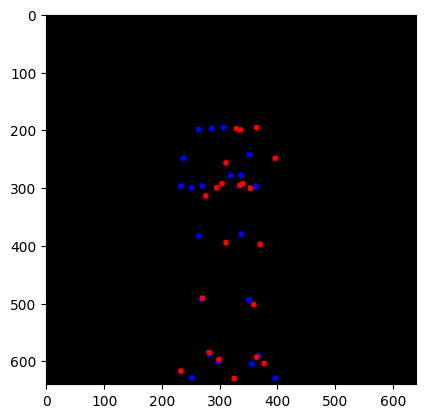

In [10]:
from mediapipe_inference import get_detection
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scoring import refine_landmarks


def normalize_landmarks_to_range(landmarks1, landmarks2):
    """
    Normalize landmarks2 to match the coordinate range of landmarks1.

    Parameters:
        landmarks1 (numpy array): Keypoints array for the first pose (num_selected_point, 4).
        landmarks2 (numpy array): Keypoints array for the second pose (num_selected_point, 4).

    Returns:
        numpy array: Normalized landmarks2 matching the range of landmarks1.
    """
    # Calculate min and max for landmarks1 and landmarks2
    min1 = np.min(landmarks1[:, :3], axis=0)  # (x_min, y_min, z_min) for landmarks1
    max1 = np.max(landmarks1[:, :3], axis=0)  # (x_max, y_max, z_max) for landmarks1

    min2 = np.min(landmarks2[:, :3], axis=0)  # (x_min, y_min, z_min) for landmarks2
    max2 = np.max(landmarks2[:, :3], axis=0)  # (x_max, y_max, z_max) for landmarks2

    # Normalize landmarks2 to the range of landmarks1
    normalized_landmarks2 = (landmarks2[:, :3] - min2) / (max2 - min2) * (max1 - min1) + min1

    # Combine normalized coordinates with the original visibility values
    normalized_landmarks2 = np.hstack((normalized_landmarks2, landmarks2[:, 3:4]))

    return normalized_landmarks2


def draw_landmarks_on_blank_image(landmarks1, landmarks2, image_size=(640, 640)):
    """
    Draw two sets of landmarks on a blank image.

    Parameters:
        landmarks1 (numpy array): Keypoints array for the first pose (num_selected_point, 4).
        landmarks2 (numpy array): Keypoints array for the second pose (num_selected_point, 4).
        image_size (tuple): Size of the blank image (height, width).

    Returns:
        numpy array: Image with landmarks visualized.
    """
    # Create a blank image
    blank_image = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)

    # Normalize coordinates to fit within the image size
    def normalize_coordinates(landmarks, image_size):
        height, width = image_size
        normalized_landmarks = []
        for landmark in landmarks:
            x, y = int(landmark[0] * width), int(landmark[1] * height)
            normalized_landmarks.append((x, y))
        return normalized_landmarks

    # Normalize landmarks
    normalized_landmarks1 = normalize_coordinates(landmarks1, image_size)
    normalized_landmarks2 = normalize_coordinates(landmarks2, image_size)

    # Draw landmarks1 (red)
    for x, y in normalized_landmarks1:
        cv2.circle(blank_image, (x, y), radius=5, color=(0, 0, 255), thickness=-1)

    # Draw landmarks2 (blue)
    for x, y in normalized_landmarks2:
        cv2.circle(blank_image, (x, y), radius=5, color=(255, 0, 0), thickness=-1)

    # Optionally connect landmarks (example: skeletal connections can be added here)
    # You can define a list of connections (e.g., POSE_CONNECTIONS) to draw lines between keypoints.

    return blank_image

p1 = "../images/승윤팔짱1.jpg"
p2= "../images/준일팔짱.jpg"
l1, seg1, ann_img1, bs1 = get_detection(p1)
l2, seg2, ann_img2, bs2 = get_detection(p2)
np_l1 = refine_landmarks(l1)
np_l2 = refine_landmarks(l2)
np_l2 = normalize_landmarks_to_range(np_l1, np_l2)

from keypoint_map import KEYPOINT_MAPPING, SELECTED_KEYPOINTS
for i in range(np_l1.shape[0]):
    print(f"difference of keypoint {KEYPOINT_MAPPING[SELECTED_KEYPOINTS[i]]}: {np.linalg.norm(np_l2[i] - np_l1[i])}")

plt.imshow(draw_landmarks_on_blank_image(np_l1, np_l2))
plt.show()